In [1]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd

from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

    
def target_1d(subimg,specaps,ds):    
    flux, unc = subimg.extract_spectrum(specaps)
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])
    return (flux, unc)

#below kinda replaces 'target_1d' above
#defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

# Subtracting Instrument Noise

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
#stating specific files/names to search for later on

flatid = 'DomeFlat'
atlasfiles = fits.open('henear.fits') #use for creating dispersion solution later 
targetID = '79005021831220-Catch22'
all_side_files_target = 'DoubleSpec/20170518/red*.fits'

#determing what instumentation noise is
flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)   
header = atlasfiles[0].header    
    
#locating all files w/ the target & instrumentation noise subtraction
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
#specs is the inst. noise subtracted group of files with data from target    
    
print("This is lenspecs:",len(specs))

print('specs is the inst. noise subtracted group of files with data from target ')

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 5
specs is the inst. noise subtracted group of files with data from target 


# Creating Dispersion Solution

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


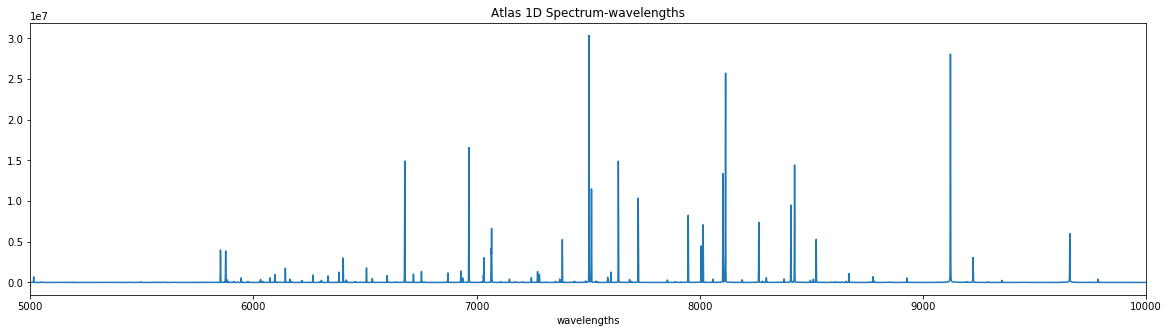

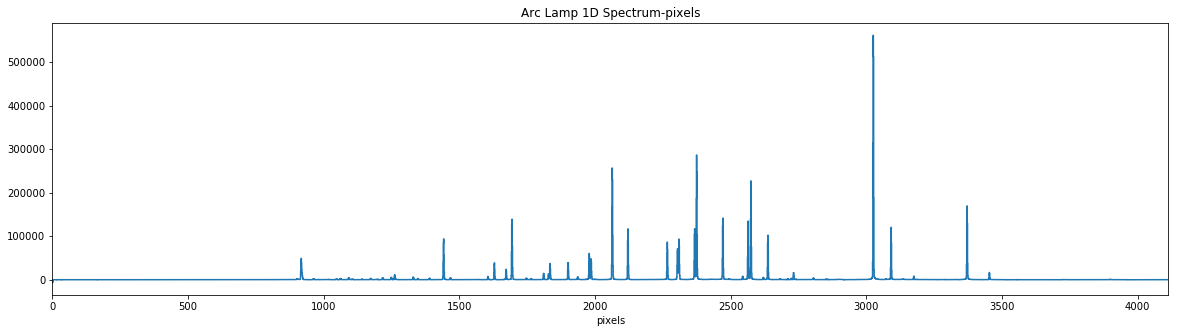

In [4]:
#creating a ds _ part one

#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = pipeline.dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10,flatid)

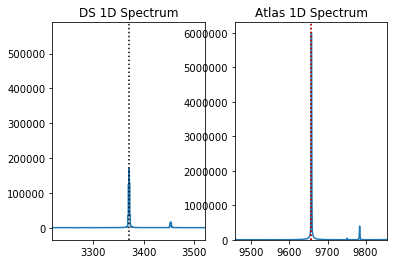

In [5]:
#creating a ds _ part two


#collecting guesses of matching lines from above graphs
#entering (px,wl)guesses & data
pipeline.guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line KrI at wl=7587.413: "Guessed line's peak to base ratio is 1.0819554378142586, which is less than 10"
Failed to find line KrI at wl=7601.5443: "Guessed line's peak to base ratio is 1.0525916052067257, which is less than 10"
Found line ArI at wl=7635.106
Clipped 0 lines
Failed to find line KrI at wl=7685.246: "Tried to find peak at 2095.7102377360125 but it's in a valley, not a peak"
Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 0.9487211223641862, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 1.1041302787798228, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 1.1153847553894787, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Tried to find peak at 2243.4658680624693 but it's in a valley, not a peak"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to b

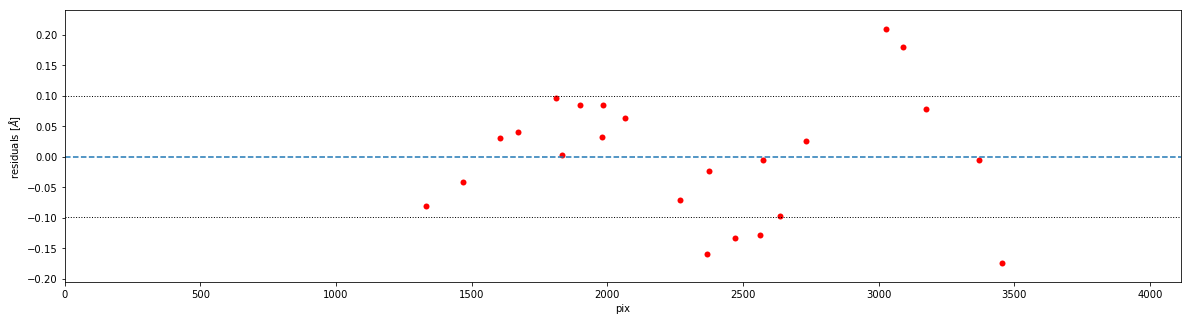

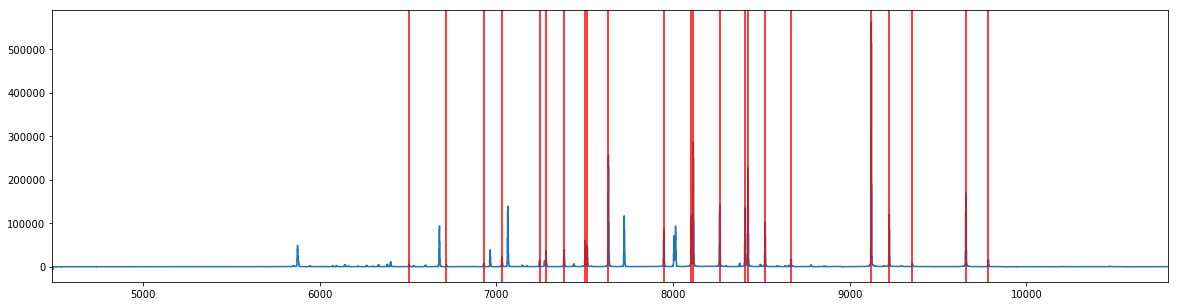

In [6]:
#creating a ds _ part three
ds_red10 = pipeline.goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10,flatid);

#this is the final ds to apply to catch22 data for this entire nb

# Sky Subtraction & stacking - data still 2D

In [7]:
#stacking all those instrument-noise-subtracted target data files-help increase s/n 

comb = reduce_dblspec.combine_imgs(specs) #comb-all files data from target stacked
skyaps=[(20,33),(265,320)]#[(55,120),(190,350)] #target 35-260
#skyaps=[(30,110),(180,400)] 
model=('poly',2)

subimg2, comb2, fitmodels = sky_subtract(comb,skyaps,model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

## SANITY CHECK

[ -6.35448395e+01   6.67014764e+01  -8.01993183e+02 ...,  -1.46522451e-01
  -3.74183006e-01  -1.10346141e+00]


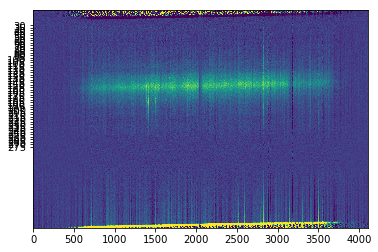

In [8]:
# SANITY CHECK

#first: want to see this newly cleaned 2d data visually
mydata=subimg2.data
vmin=-10
vmax=45
#plt.figure(figsize=(25,20)) ##REMOVE THIS LINES # TO SEE GRAPH USEFULNESS!!!!!!!!!!!!!!!!!!!!!!!!!

#instead of show_image function at top, doing this to estimate spatial row limits of H-alpha emission 
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
plt.yticks(np.arange(30,280,5))
plt.imshow(mydata,aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)

#second: now want to see newly cleaned data in numbers
print(subimg2.data[::][0])

# Extracting 2D target spectrum (reducing spatial parameters)

FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!
flux data shape: (226, 4104)
NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


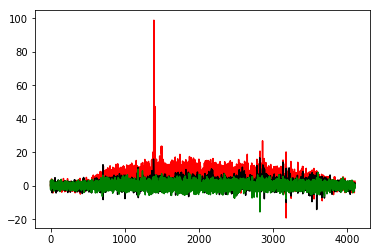

In [9]:
#first need to get 1D spectrum for each spatial pixel row in the 2D target data

#extracting target spec from whole 2d spec
target_aperature=(35,260) #target location

flux_data=[] #empty list to hold target 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #makes list for which rows to extracct spec from
#print (apslc) #as expected, +1 so doesnt cut off last value

#np.shape(subimg2.data)#(440, 4114)
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects a list of every row's spec within the target location
flux_data=np.array(flux_data)   
print("FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!" )
#need to find a way to sum over diff ranges of apslc 

#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #this wont affect spatial axes pix values, only amount of flux but thats negligible


plt.plot(flux_data[145],color='r')#near galaxy center
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[224],color='g')#near opposite galaxy edge

print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

## SANITY CHECK - BAD

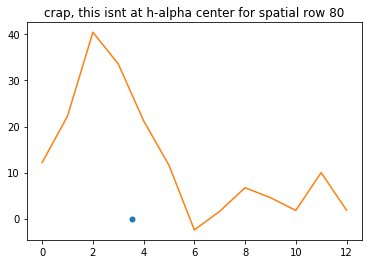

In [10]:
#good
#centroid testing in halpha reduced wl range....no ds applied

#cutting flux array to see wl's around H-alpha
flux_data_short2 = flux_data[:,1387:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho

row = 80 #change which spatial row visualizing here

#doing centroid testing on individual rows to see if centroid = halpha center 
testha = flux_data_short2[row] #specifying one row to test h-alpha centroid
testnewha = testha[np.newaxis,:] #converting 1d array into a 'fake' 2d array for next line
x,y = centroid_com(testnewha) #centroiding fcn requires 2d array input

#plotting results
plt.plot(x,y,'.',markersize=10)
plt.plot(testha);
plt.title('crap, this isnt at h-alpha center for spatial row {:}'.format(row))
#print(np.shape(testnewha)) #confirms made into fake 2d array
#print(testnewha[0])

# Continnum Subtraction for Entire Target

shape new: (226, 4104)
new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array


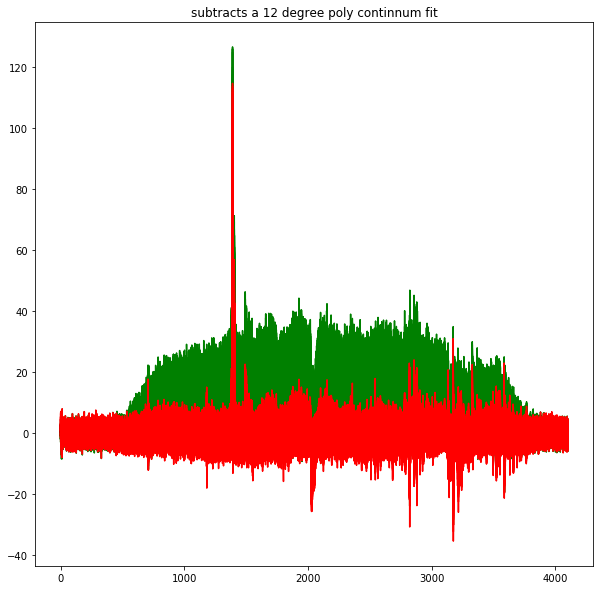

In [11]:
#good
#fitting continum for entire target now

#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
spatial_indexes = np.arange(0,len(flux_data))
new = []


for row in flux_data: #i isnt indiv data its each spatial row of data
    xpix = np.arange(0,len(row),1) #lists pixels by index
    polydeg = 12 #what degree of line to fit to continnum
    poly = np.poly1d(np.polyfit(xpix,row, polydeg)) #this determines the fit of the continum
    spec_subtracted = row - poly(xpix)
    new.append(spec_subtracted)
new = np.array(new)

divide = 4104 #number of spectral pixels in target data 
amtofrows = int(len(new)/divide) #also ensured int not float
plt.figure(figsize=(10,10))

print('shape new:',np.shape(new))

plt.plot(flux_data.T, color='g'); #original data
plt.plot(new.T,color='r'); #continum subtracted data
plt.title('subtracts a {:} degree poly continnum fit'.format(polydeg))

print('new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array')


## REPEATED BAD SANITY CHECK- good now

### Still need way to automate H-alpha wl pix range when doing cut

new blue dot 2.41862680072 0.0
old blue dot 3.7462368393 0.0
This seems to work well for rows close to core, but very poor for farther distances - erik says ok b/c expect oscills & irregular dwarfs for a reason 


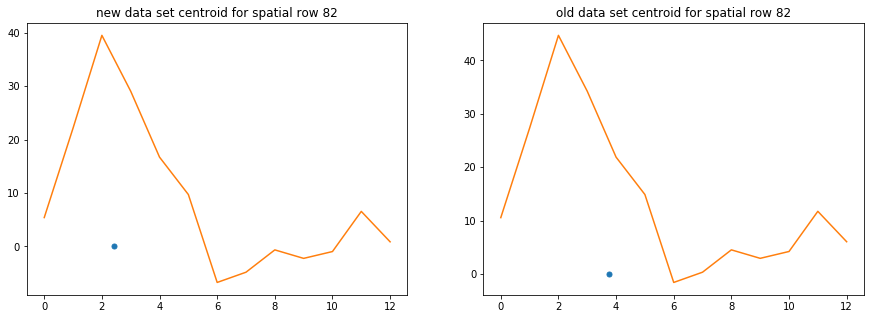

In [12]:
#new data centroiding

new_short = new[:,1387:1400] #still guessing - need convert pix to wl here somehow
#guess will be calculated from target's z estimate of h-alpha wl location---will need to apply ds tho

row = 82 #change spatial row viewing here
#62, 27, 222 bad
#82, 122, 182 good


#new continum subt data
new_testha = new_short[row]
new_testha2 = new_testha[np.newaxis,:]
x2,y2 = centroid_com(new_testha2)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(x2,y2,'.',markersize=10)
ax1.plot(new_testha);
ax1.set_title('new data set centroid for spatial row {:}'.format(row))


#original data from above bad sanity check just replotting for comparison here
testha = flux_data_short2[row] #gets weird near end of range 0-226
testnewha = testha[np.newaxis,:] #converting 1d array into a 'fake' 2d array 
x,y = centroid_com(testnewha) #centroiding fcn requires 2d array input
ax2.plot(x,y,'.',markersize=10)
ax2.plot(testha);
ax2.set_title('old data set centroid for spatial row {:}'.format(row))
print('new blue dot',x2,y2)
print('old blue dot',x,y)
print('This seems to work well for rows close to core, but very poor for farther distances - erik says ok b/c expect oscills & irregular dwarfs for a reason ')

# Getting Galaxy Core to Center Rot. Curve around

### First Making 1D Spectrum

In [13]:
#no time to figure out why this aperture gives errors when doing the uncertaining within the function
side = 'red'
subtracted_2d = flux_data #(226,4104)
aperture = (1,225)
#extract_spectrum(side, subtracted_2d, aperture)

shape (226, 1)
x: 0.0 y: 117.150852463 y is the spatial core location still in pixels & in the Reduced spectral range
to get full plate scale pix value add 35 and 10 from 1D spec cut due to oscillations
GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL: 152.150852463
SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!
double check corrections after decide about 10 pix cut around ln[8]


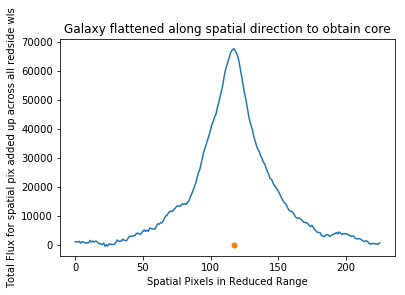

In [14]:
#hack way of doing above without a nice function

#flattening to be along spatial direction (histogram like)
flux_array = np.sum(flux_data,axis=1) #explicitly making an array
flux_array2d = flux_array[:, np.newaxis] #need 2d for centroiding


print('shape',np.shape(flux_array2d))
x_galcore, y_galcore = centroid_com(flux_array2d) #actually doing the centroiding

#plotting
plt.plot(flux_array2d);
plt.plot(y_galcore, x_galcore ,'.',markersize=10)
plt.xlabel('Spatial Pixels in Reduced Range')
plt.ylabel('Total Flux for spatial pix added up across all redside wls')
plt.title('Galaxy flattened along spatial direction to obtain core')

#below is amt of pix to add to target pix value to get matching plate pix #doesnt help total len tho
space_pix_correction = target_aperature[0] #from ln[9] in 1d target extract; maybe need to do this->#10 from pix cut from oscill in 1D
spatial_core_pix = y_galcore + space_pix_correction #(adds 35 to correct from target extraction),(10 from oscillations doesnt affect this b/c of spectral collapse in sum)

#conclusions
print('x:',x_galcore,'y:',y_galcore, 'y is the spatial core location still in pixels & in the Reduced spectral range')
print('to get full plate scale pix value add {:} and 10 from 1D spec cut due to oscillations'.format(target_aperature[0]))
print('GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL:',spatial_core_pix)
print('SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!')
print('double check corrections after decide about 10 pix cut around ln[8]')

### Redoing core b/c spectral tilt is drastically effecting core location within H-alpha

### READ BELOW 'lower_two' NOTES FOR H-ALPHA WL RANGE POTENTIAL PROBLEM ---easy to fix later tho if needed

shape of first section: (226, 50) matches shape of second section: (226, 50)
shape of first section 2d: (226, 1)
shape of second section 2d: (226, 1)
first section centroid x,y: 0.0 119.587708122
second section centroid x,y: 0.0 118.823788586
This is the average pixel value of the core BEFORE spatial cutout corrections 119.205748354
Pixel Value of core along spatial axis wrt full CCD size 154.205748354


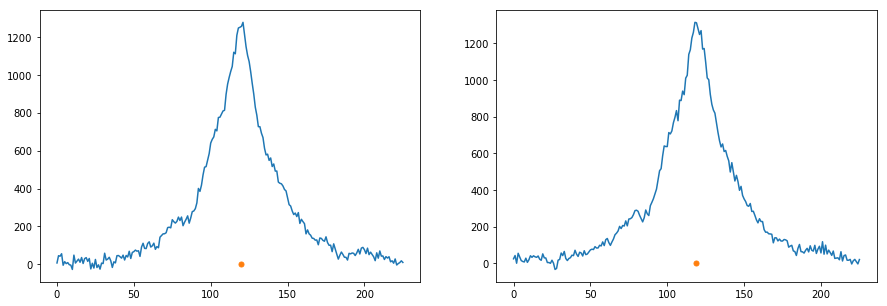

In [15]:
np.shape(flux_data)#(226,4104) #note that this is missing those 10 wl's
#also note flux_data is continuum subtracted

#below verifying h-alpha wl range along with #plot
harange_if10missing = flux_data[:,1377:1405] #flux_data off by 10 so subtract 10 from usual h-alpha's wl-in-pixspace range 
#plt.plot(harange_if10missing[11]); #saw clear ha peak so good

#making arrays surrounding h-alpha
upperha = 1405
lowerha = 1377
width_sections = 50
upper_one = lowerha - 1 #just to give it some distance
lower_one = upper_one - width_sections
lower_two = upperha + 5 #needed more distance (near&below core H-alpha leaks into this range so IF change ha range then make this 5 a 1 )
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))
#plt.plot(second_section[120]); #tried many diff row values for both sections here - satisified correct


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
x_first, y_first = centroid_com(first_section2d)
x_second, y_second = centroid_com(second_section2d)
print('first section centroid x,y:',x_first,y_first)
print('second section centroid x,y:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)

#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE spatial cutout corrections',core_avgcentroids)

#corrections to pixel value of avg section core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)



In [16]:
#this one line switches full spectral CCD determined core to the core determined from spectral sections surrounding halpha

#spatial_core_pix = core_from_sections

# H-alpha Centroids for Entire Target

wl_pix_corrected defined here
len 226 <class 'numpy.ndarray'> (226,)
len 226 <class 'numpy.ndarray'> (226,)
double check corrections after decide how to deal with 10 pix cut from around ln[8]


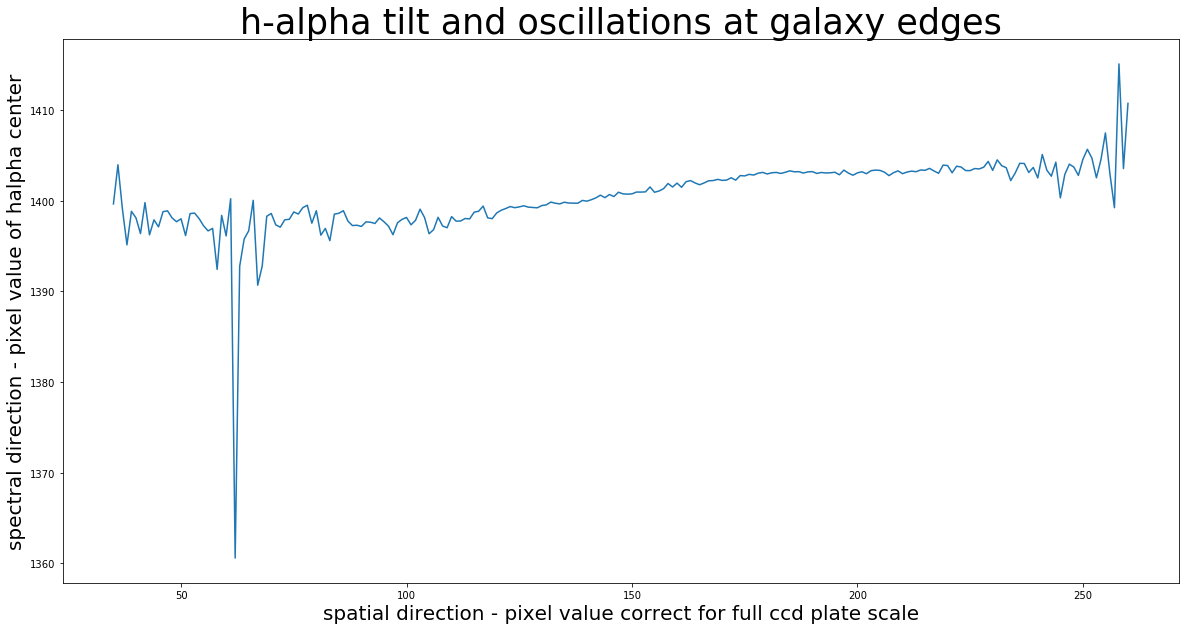

In [17]:
#good
#gets h-alpha centroid values for every spatial row within the target range 

#below for reference, uses full ccd wl range - first defined when applied DS
wl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))
wl_shorter2 = wl[1387:1400] #isolate wl around h-alpha using full ccd plate wl range



mylist2 = []
mylist_ys2 = []
holding2 = []
ha_wls2 = []
##below for reference- new is continuum subst target flux data (flux_data has 10 wl cut)
#concerned 10 wl cut means 10 flux cut too in the lenght of the data but cant decide
#if the 10 is already accounted for by +1387 or should also add into space_pix_correction2
#b/c that 10 cut cutout those wl's and corresponding fluxes
##new_short = new[:,1387:1400] #cut to isolate wl around h-alpha

#gets halpha centroids in target gal's range
for row in new_short:
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    #print('row?',flux_fake2d)
    mylist4, mylist5 = centroid_com(flux_fake2d2)#finds center(x,y) of halpha for each row array
    #print(mylist4, mylist5)
    holding_arr2 = row, wl_shorter2
    x = np.array([row,wl_shorter2])
    mylist_ys2.append(mylist5)
    mylist2.append(mylist4) #collects all halpha centers per row
mylist2=np.array(mylist2) #halpha centroids (wl) array

#correction for target wl pix's to match index of full ccd plate pix's (still not correct len but dont care about below target pixs-no data there neway)
wl_pix_corrected = mylist2 + wl_pix_correction + 1387 #decide how to better automate/track this
print('wl_pix_corrected defined here')
#dont have to account for osciallations b/c used full ccd plate range b4 wl cut 4 h-alpha isolation
space_pix_correction2 = np.arange(len(mylist2)) + space_pix_correction

print('len',len(mylist2),type(mylist2), np.shape(mylist2))
print('len',len(space_pix_correction2),type(space_pix_correction2), np.shape(space_pix_correction2))


print('double check corrections after decide how to deal with 10 pix cut from around ln[8]')
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
plt.plot(space_pix_correction2,wl_pix_corrected)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha tilt and oscillations at galaxy edges',fontsize=35)
#plt.ylim(-1,10)

# Applying DS --pix to wl associations for velocity axis (spectral) 

In [18]:
#good but unnecessary
''' 
#applying ds to get wl-pix associations

#first use original data to get correct wl/pix ranges to correct for cuts above
print('verifying ccd plate/original data len',len(subimg2.data[::][0])) #original 2D data


#applying DS

#wl to pix association
wl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))

#pix to wl association
px = []
for i in wl:
    i = int(i)
    pix = ds_red10.wltopix(i)
    px.append(pix)
px = np.array(px)


#checking ds gave 1-1 px-wl associations
print('wl:',wl)
print('px:',px)
print('px len:',len(px))
print('wl len:',len(wl))

#make this a table to carry around associations
index = np.arange(0,len(wl))
dst = Table([index, wl, px], names=('index', 'wl', 'px'))
#dst #table of conversions between wl & pix plus an index to call indiv rows from table easily
'''

" \n#applying ds to get wl-pix associations\n\n#first use original data to get correct wl/pix ranges to correct for cuts above\nprint('verifying ccd plate/original data len',len(subimg2.data[::][0])) #original 2D data\n\n\n#applying DS\n\n#wl to pix association\nwl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))\n\n#pix to wl association\npx = []\nfor i in wl:\n    i = int(i)\n    pix = ds_red10.wltopix(i)\n    px.append(pix)\npx = np.array(px)\n\n\n#checking ds gave 1-1 px-wl associations\nprint('wl:',wl)\nprint('px:',px)\nprint('px len:',len(px))\nprint('wl len:',len(wl))\n\n#make this a table to carry around associations\nindex = np.arange(0,len(wl))\ndst = Table([index, wl, px], names=('index', 'wl', 'px'))\n#dst #table of conversions between wl & pix plus an index to call indiv rows from table easily\n"

In [19]:
#this applys ds to centroid pix values to get true wl's
centroids_wl = ds_red10.pixtowl(wl_pix_corrected)*u.angstrom



# SKIP until resume

In [20]:
#testing why some values in mylist2 (ha centroids) are negative
''' 
a = new_short[27]
d = new[25:30,1414]
luna = ([new_short[27]]) #makes array into a list



b = a[np.newaxis, :]
x,y = centroid_com(b)
f, ((ax1, ax2),(ax3)) = plt.subplots(2,2,figsize=(15,5))
ax1.plot(x,y, 'o',color='g')
ax1.plot(a, color='r')
ax2.plot(d, color='g')

#ax3.plot(luna) #refuses to see it as anything but an array idk why oh well
#plt.plot(mylist2[27], color='g')
'''

" \na = new_short[27]\nd = new[25:30,1414]\nluna = ([new_short[27]]) #makes array into a list\n\n\n\nb = a[np.newaxis, :]\nx,y = centroid_com(b)\nf, ((ax1, ax2),(ax3)) = plt.subplots(2,2,figsize=(15,5))\nax1.plot(x,y, 'o',color='g')\nax1.plot(a, color='r')\nax2.plot(d, color='g')\n\n#ax3.plot(luna) #refuses to see it as anything but an array idk why oh well\n#plt.plot(mylist2[27], color='g')\n"

In [21]:
#trying to see this is full dataset (not ha isolated wl range)
''' 
d = new[:,1414]
plt.plot(d)
plt.xlim(25,30)
plt.ylim(-1,1)
for i in new_short[27]:
    print(i)
    '''

' \nd = new[:,1414]\nplt.plot(d)\nplt.xlim(25,30)\nplt.ylim(-1,1)\nfor i in new_short[27]:\n    print(i)\n    '

In [22]:
#print('pretend mylist2 negative values are ok....pretty sure its just due to inadequate flux')

In [23]:
''' 
np.arange(len(mylist2)) #0-225 array
space_pix_correction #35
#below defined above 'SKIP'
space_pix_correction2 #35-260 array #pix value of spatial row in target range corrected wrt entire ccd plate size
spatial_core_pix #152.150....+10 added when defined so now its 162.15.....
space_pix_correction2
'''

" \nnp.arange(len(mylist2)) #0-225 array\nspace_pix_correction #35\n#below defined above 'SKIP'\nspace_pix_correction2 #35-260 array #pix value of spatial row in target range corrected wrt entire ccd plate size\nspatial_core_pix #152.150....+10 added when defined so now its 162.15.....\nspace_pix_correction2\n"

# RESUME

# Converting Pixels --> kpc 

In [24]:
#centering  around core......chose on distance axis for now

#below for reference
#wl_pix_correction2 is pix of ha centroid in full plate scale
#space_pix_correction2 is row pix of each centroid
#spatial_core_pix is pixel value of the galaxy core in full plate scale


distance_pix_wrtcore = space_pix_correction2 - spatial_core_pix #for core wl using full ccd
distance_pix_wrtcore_sections = space_pix_correction2 - core_from_sections #for core wl using 2 sections around Halpha



#print('space',space_pix_correction2)
#print('location', location_pix)

In [25]:
#maybe delete
''' 
arcmins = []

for i in space_pix_correction2:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    #print(type(r_in_arcmin)) #astropy.units.quantity.Quantity
    #r_in_arcmin.append(arcmins)
    #arcmins.append(r_in_arcmin)
#armins = np.array(arcmins)
#print(arcmins)
'''

" \narcmins = []\n\nfor i in space_pix_correction2:\n    r_in_arcmin = 1*u.arcmin\n    redplatescale = 0.293*u.arcsec/u.pixel\n    dbsp_pix_equiv = u.pixel_scale(redplatescale)\n    r_in_pixel = i*u.pixel\n    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)\n    #print(type(r_in_arcmin)) #astropy.units.quantity.Quantity\n    #r_in_arcmin.append(arcmins)\n    #arcmins.append(r_in_arcmin)\n#armins = np.array(arcmins)\n#print(arcmins)\n"

In [26]:
#maybe delete
''' 
distance = 37*u.Mpc # distance of object from us
another =[]
for i in armins:
    r_in_kpc = (i/u.rad*distance).to("kpc")
    another.append(r_in_kpc)
another = np.array(another)
another'''

' \ndistance = 37*u.Mpc # distance of object from us\nanother =[]\nfor i in armins:\n    r_in_kpc = (i/u.rad*distance).to("kpc")\n    another.append(r_in_kpc)\nanother = np.array(another)\nanother'

In [27]:
#good for core defined from full CCD
#converts pixels to kpc (distance profile)
arcmins = []
another =[]
more = []

#below for reference
#distance_pix_wrtcore = space_pix_correction2 - spatial_core_pix


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore:#space_pix_correction2:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    #print(type(r_in_arcmin))
    distance = 37*u.Mpc # distance of object from us
    r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc")
    #print(r_in_kpc)
    ##more = [r_in_kpc]
    more = r_in_kpc
    another.append(more)
#another = np.array(another)
another

    

[<Quantity -6.157290788788212 kpc>,
 <Quantity -6.104732137619127 kpc>,
 <Quantity -6.052173486450042 kpc>,
 <Quantity -5.999614835280957 kpc>,
 <Quantity -5.947056184111872 kpc>,
 <Quantity -5.894497532942786 kpc>,
 <Quantity -5.841938881773702 kpc>,
 <Quantity -5.7893802306046185 kpc>,
 <Quantity -5.736821579435533 kpc>,
 <Quantity -5.684262928266448 kpc>,
 <Quantity -5.631704277097363 kpc>,
 <Quantity -5.579145625928278 kpc>,
 <Quantity -5.526586974759193 kpc>,
 <Quantity -5.47402832359011 kpc>,
 <Quantity -5.421469672421025 kpc>,
 <Quantity -5.3689110212519395 kpc>,
 <Quantity -5.316352370082854 kpc>,
 <Quantity -5.26379371891377 kpc>,
 <Quantity -5.211235067744684 kpc>,
 <Quantity -5.1586764165756 kpc>,
 <Quantity -5.106117765406516 kpc>,
 <Quantity -5.053559114237431 kpc>,
 <Quantity -5.001000463068346 kpc>,
 <Quantity -4.948441811899261 kpc>,
 <Quantity -4.895883160730176 kpc>,
 <Quantity -4.843324509561091 kpc>,
 <Quantity -4.790765858392006 kpc>,
 <Quantity -4.738207207222922 

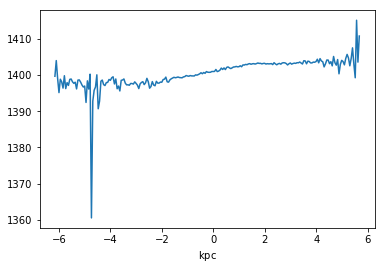

In [28]:
#good  for core defined from full CCD
#demonstrating a BETTER WAY to plot quantity arrays thats easier than what i did above and below to get it to plot
plt.plot(u.Quantity(another), wl_pix_corrected)

In [29]:
#good for core defined by 2 sections around halpha
#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []

#below for reference
#distance_pix_wrtcore = space_pix_correction2 - spatial_core_pix


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:#space_pix_correction2:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    distance = 37*u.Mpc # distance of object from us
    r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc")
    more_sections = r_in_kpc
    distances_sections.append(more_sections)
#another = np.array(another)
distances_sections

[<Quantity -6.265293345080152 kpc>,
 <Quantity -6.2127346939110675 kpc>,
 <Quantity -6.160176042741984 kpc>,
 <Quantity -6.107617391572897 kpc>,
 <Quantity -6.055058740403814 kpc>,
 <Quantity -6.002500089234728 kpc>,
 <Quantity -5.949941438065643 kpc>,
 <Quantity -5.897382786896558 kpc>,
 <Quantity -5.844824135727474 kpc>,
 <Quantity -5.7922654845583885 kpc>,
 <Quantity -5.739706833389305 kpc>,
 <Quantity -5.687148182220219 kpc>,
 <Quantity -5.634589531051135 kpc>,
 <Quantity -5.5820308798820495 kpc>,
 <Quantity -5.529472228712965 kpc>,
 <Quantity -5.47691357754388 kpc>,
 <Quantity -5.424354926374796 kpc>,
 <Quantity -5.3717962752057105 kpc>,
 <Quantity -5.319237624036626 kpc>,
 <Quantity -5.266678972867541 kpc>,
 <Quantity -5.214120321698456 kpc>,
 <Quantity -5.161561670529371 kpc>,
 <Quantity -5.109003019360286 kpc>,
 <Quantity -5.056444368191202 kpc>,
 <Quantity -5.003885717022117 kpc>,
 <Quantity -4.951327065853032 kpc>,
 <Quantity -4.898768414683948 kpc>,
 <Quantity -4.84620976351

(1395, 1410)

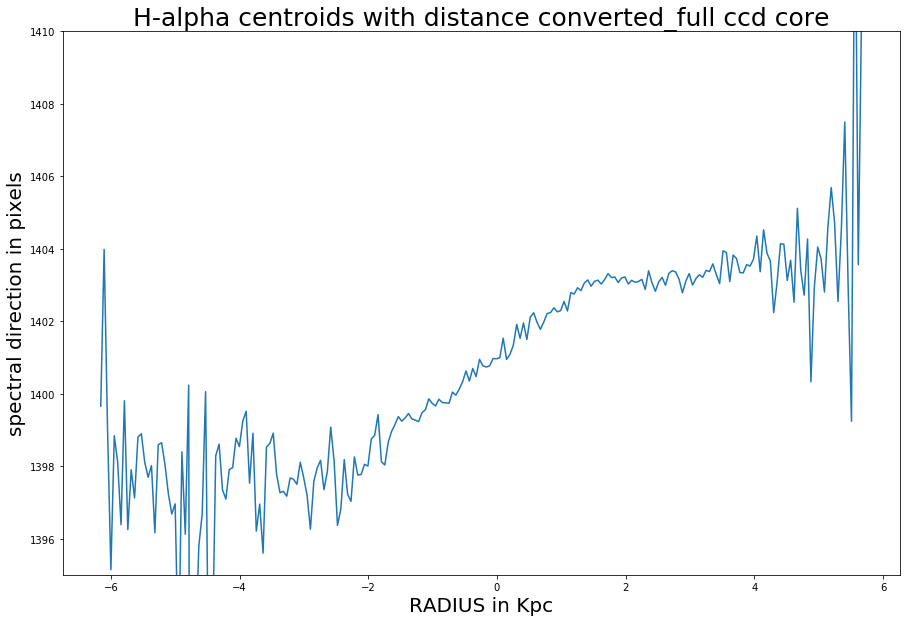

In [30]:
#good for core using full CCD
plt.figure(figsize=(5,3))

plt.figure(figsize=(15,10))
plt.plot(another * u.kpc,wl_pix_corrected)
plt.title('H-alpha centroids with distance converted_full ccd core',fontsize=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)


plt.ylim(1395,1410)

(1395, 1410)

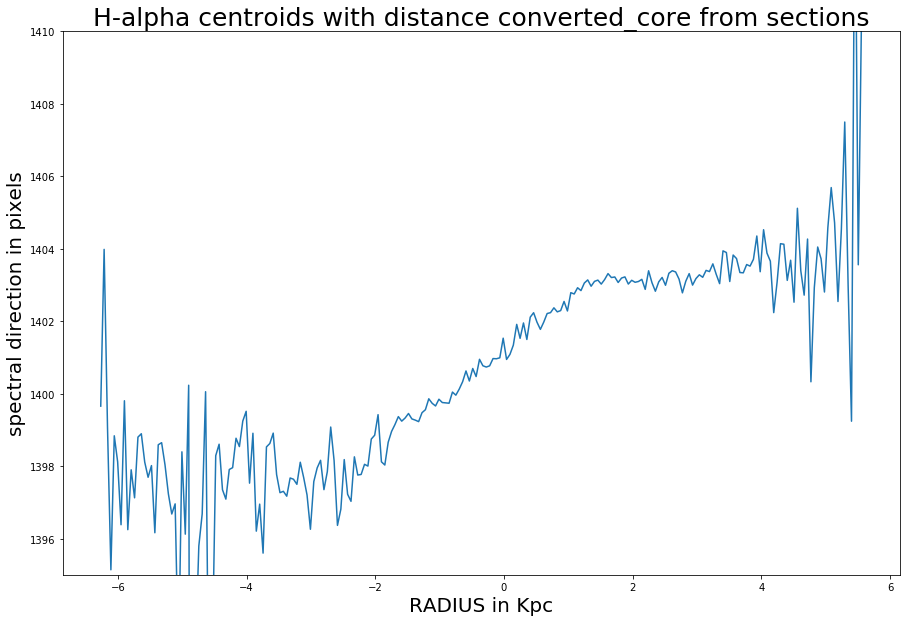

In [31]:
#good for core defined using 2 sections around halpha
plt.figure(figsize=(5,3))

plt.figure(figsize=(15,10))
plt.plot(distances_sections * u.kpc,wl_pix_corrected)
plt.title('H-alpha centroids with distance converted_core from sections',fontsize=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)


plt.ylim(1395,1410)

In [32]:
#exploring core problem, but solved above already

irange = np.arange(len(wl_pix_corrected))
table= Table([irange, wl_pix_corrected,u.Quantity(another)], names=('index','wl','kpc')) #core full ccd
table3= Table([irange, wl_pix_corrected,u.Quantity(distances_sections)], names=('index','wl','kpc')) #core from sections
table4=table3[np.where(table['kpc']==0.0)] #core from sections
table2=table[np.where(table['kpc']==0.0)] #core full ccd
table2 #core full ccd
table4 #core using sections
print('zero centered core problem b/c radius data never exactly =0 for both ways of defing core')
#for i in table:
#    print(i)
table[117:119] #core using full ccd
table3[119:121] #core using sections

zero centered core problem b/c radius data never exactly =0 for both ways of defing core


index,wl,kpc
,,kpc
int64,float64,float64
119,1401.52920714,-0.0108138559591
120,1400.94255929,0.04174479521


# Converting wl to velocity

In [33]:
#skip

#trys to match centroid array to ds table with wl/pix associations- but diff lengths problems
""" 

#below for reference
#wl_pix_correction2 is pix of ha centroid in full plate scale


#making centroid array same length to add to dst, need to add zeros to slots above & below target range
begin = np.arange(0,1387)
#print(len(begin))
#end = np.arange()

#n/m try new method of cutting table instead?
#dst2['ha centroids']= 

#need to get these pixs into wl via ds
wl_pix_corrected # pixel value of ha centroids

#problem with below is lengths of table and array dont match
#dst['ha centroids pix']= wl_pix_corrected
#dst

print('test start',wl_pix_corrected[0])
print('test end',wl_pix_corrected[-1])
end = int(wl_pix_corrected[-1]) + 2 #added 2 so px table column included  ha centroids pix range
print('end',end)
#first need to cut dst table so length matches lenght of list of ha centroid pix values
##low = np.where(dst['index'] == int(wl_pix_corrected[0]))#trying np where to connect table row index to lowest ha centroid wl
##print('low',low)
start = int(wl_pix_corrected[0])
print('start',start)
dst2 = dst[start:end]

print('could try an interpolation?? to get a "real" wl value for each centroid pix')
dst2
"""

' \n\n#below for reference\n#wl_pix_correction2 is pix of ha centroid in full plate scale\n\n\n#making centroid array same length to add to dst, need to add zeros to slots above & below target range\nbegin = np.arange(0,1387)\n#print(len(begin))\n#end = np.arange()\n\n#n/m try new method of cutting table instead?\n#dst2[\'ha centroids\']= \n\n#need to get these pixs into wl via ds\nwl_pix_corrected # pixel value of ha centroids\n\n#problem with below is lengths of table and array dont match\n#dst[\'ha centroids pix\']= wl_pix_corrected\n#dst\n\nprint(\'test start\',wl_pix_corrected[0])\nprint(\'test end\',wl_pix_corrected[-1])\nend = int(wl_pix_corrected[-1]) + 2 #added 2 so px table column included  ha centroids pix range\nprint(\'end\',end)\n#first need to cut dst table so length matches lenght of list of ha centroid pix values\n##low = np.where(dst[\'index\'] == int(wl_pix_corrected[0]))#trying np where to connect table row index to lowest ha centroid wl\n##print(\'low\',low)\nstart

In [34]:
#skip
"""
#the index of the centroid array should match the index in the table array tho

anarray = np.arange(35,len(wl_pix_corrected)+1,1)
#print(anarray)
for i in anarray:
    a = np.where(dst['index'] == i)
    a
    dst3=dst[a]
dst3
"""

"\n#the index of the centroid array should match the index in the table array tho\n\nanarray = np.arange(35,len(wl_pix_corrected)+1,1)\n#print(anarray)\nfor i in anarray:\n    a = np.where(dst['index'] == i)\n    a\n    dst3=dst[a]\ndst3\n"

In [35]:
#checking values
#wl_pix_corrected

In [36]:
#trying interpolation
#from scipy.interpolate import interp1d
#ds_pixels = dst3['px']
#centroid_pixels = wl_pix_corrected
#below wont work b/c not same length
#f = interp1d(ds_pixels, centroid_pixels)


# HOST galaxy redshift calculation

In [37]:
#good
#need host z

#calculating z of host
#distance = (c*z)/hubbleconst so need --> (dist * h0) / c = z
distance = 37*u.Mpc #host dist from saga paper
H0 = 70 * u.km / u.s / u.Mpc #hubble const
c = const.c.to('km/s') #speed of light
host_z = (distance * H0)/ c 
host_z_vel = ((distance * H0)/ c ) *c

print('Catch22-host redshift:',host_z)
print('Catch22-host velocity:',host_z_vel)

Catch22-host redshift: 0.00863931006563214
Catch22-host velocity: 2590.0000000000005 km / s


In [38]:
np.shape(wl_pix_corrected)
c

<Quantity 299792.458 km / s>

# Core centering


core row 152
core wl pix value: 1403.21838556


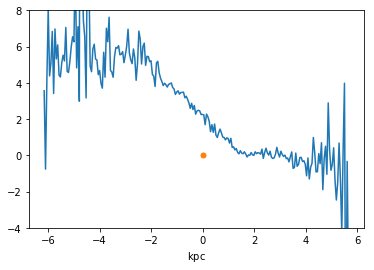

In [39]:
#PROBLEMS

#where is h-alpha centroid (wl) for spatial core row--thats core on wl side 
spatial_rowof_core = int(spatial_core_pix) #pixel value of spatial row defined as galaxy core based on 1d spec centroid
print('core row', spatial_rowof_core)
core_wl = wl_pix_corrected[spatial_rowof_core] #getting centroid wl pixel at the spatial core
print('core wl pix value:',core_wl)
#velocity = hubbleconst * distance


#making core velocity=0
relative_tocore_pix = core_wl - wl_pix_corrected

#sanity check
plt.plot(u.Quantity(another), relative_tocore_pix)
#plt.ylim(-8,4) #corepix - centroidpix
plt.ylim(-4,8) #centroidpix - corepix
plt.plot(0,0,'.',markersize=10) #checks center is core

In [40]:
#wl_pix_corrected

acore 117
core wl pix value: 1400.96156626


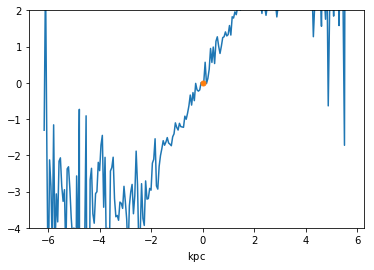

In [41]:
#good for full ccd core
#2nd attempt at above 
acore = int(spatial_core_pix) - 35 #to get acct for target spactial range cut when getting correct core index
print('acore',acore)
core_wl = wl_pix_corrected[acore]
print('core wl pix value:',core_wl)



#making core velocity=0
#relative_tocore_pix = core_wl - wl_pix_corrected #reverse this ie subtract core_wl
relative_tocore_pix = wl_pix_corrected - core_wl# rename as wl_pixshift_wrtcore

#sanity check
plt.plot(u.Quantity(another), relative_tocore_pix)
#plt.ylim(-8,4) #corepix - centroidpix
plt.ylim(-4,2) #centroidpix - corepix
plt.plot(0,0,'.',markersize=10) #checks center is core

mycore 119
core wl pix value from sections: 1401.52920714


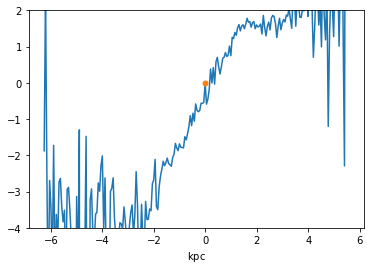

In [42]:
#good for sections defined core
mycore = int(core_from_sections) - 35 #to get acct for target spactial range cut when getting correct core index
print('mycore',mycore)
core_wl_sections = wl_pix_corrected[mycore]
print('core wl pix value from sections:',core_wl_sections)



#making core velocity=0
#relative_tocore_pix = core_wl - wl_pix_corrected #reverse this ie subtract core_wl
relative_tocore_pix_sections = wl_pix_corrected - core_wl_sections# rename as wl_pixshift_wrtcore

#sanity check
plt.plot(u.Quantity(distances_sections), relative_tocore_pix_sections)
#plt.ylim(-8,4) #corepix - centroidpix
plt.ylim(-4,2) #centroidpix - corepix
plt.plot(0,0,'.',markersize=10) #checks center is core

In [43]:
#relative_tocore_pix
#core_wl
#wl_pixshift_wrtcore

In [44]:
#print('one',len(wl_pix_corrected))
#print('two',len(spatial_core_pix))
#spatial_core_pix
##########relative_tocore_wl


In [45]:
#making pixel spread into velocities
#velocity = (relative_tocore_pix * c) / host_z

#doppler shift formula...made rest_wl=0 via core centering(=0)
#shift = rest_wl * (velocity/c) so use --> (shift * c)/core_wl_pix
##velocity = (relative_tocore_pix/core_wl) * c #not much diff betwn one sent to erik&laura
###velocity = (relative_tocore_pix * c) / core_wl #sent this one to erik&laura
#core_wl is the ha centroid wl_pix value at the galaxy core
#velocity = (relative_tocore_pix/acore) * c #gives 1000+ km/s velocities=WRONG
#velocity = (relative_tocore_pix * c) / acore #gives 10,000s km/s velocities=WRONG
#velocity = (relative_tocore_pix  / host_z) * c #gives 10**9 km/s velocities=WRONG
#velocity = (relative_tocore_pix / core_wl) * c


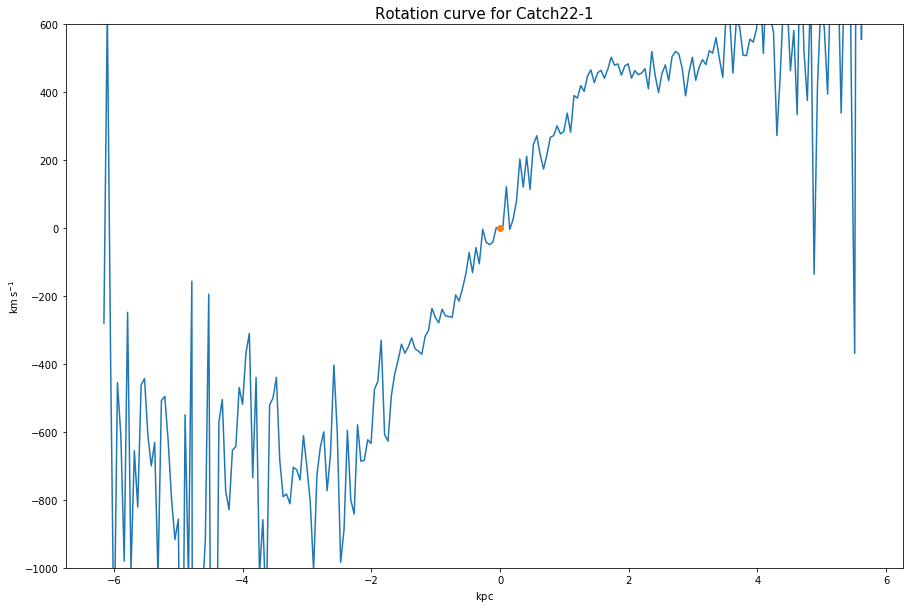

In [46]:
#sanity check for core from full ccd
velocity = (relative_tocore_pix / core_wl) * c


plt.figure(figsize=(15,10))
plt.plot(u.Quantity(another), u.Quantity(velocity))
plt.title('Rotation curve for Catch22-1',fontsize=15)
#plt.ylim(-300,900)
#plt.ylim(-850,400)
#plt.ylim(-1000,1000)
plt.ylim(-1000,600)

#hopefully = core_wl - wl_pix_corrected[162]#128
plt.plot(0,0,'o')
#plt.savefig('RC4C22')

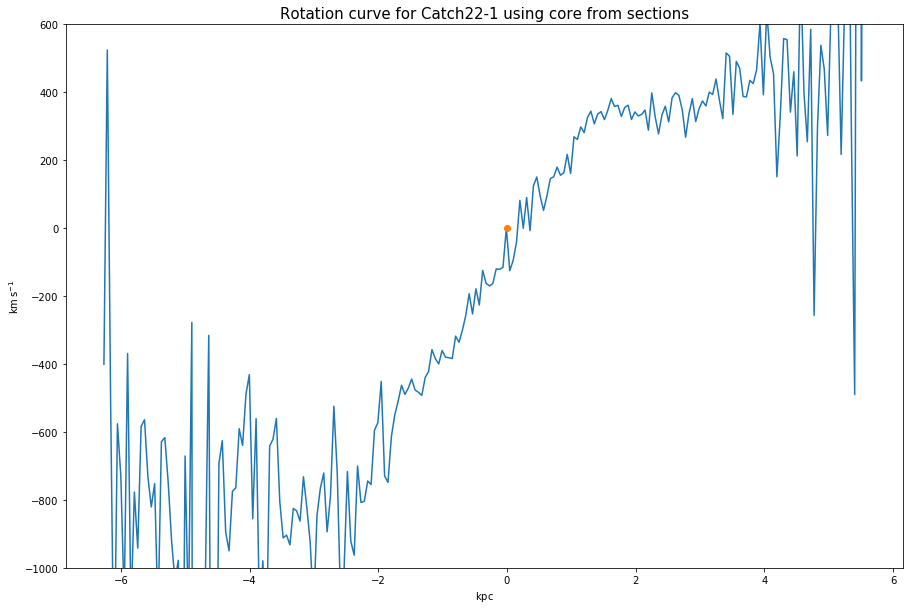

In [47]:
#sanity check for core from full ccd
velocity_sections = (relative_tocore_pix_sections / core_wl_sections) * c



plt.figure(figsize=(15,10))
plt.plot(u.Quantity(distances_sections), u.Quantity(velocity_sections))
plt.title('Rotation curve for Catch22-1 using core from sections',fontsize=15)
#plt.ylim(-300,900)
#plt.ylim(-850,400)
#plt.ylim(-1000,1000)
plt.ylim(-1000,600)

#hopefully = core_wl - wl_pix_corrected[162]#128
plt.plot(0,0,'o')

# SKIP until resume

In [48]:
''' 

#not sure, prolly was checking something
core_row = int(spatial_core_pix)
#print('core row',spatial_coreof_row)
core = wl_pix_corrected[162]
print('core:', core)

#below used to check values to be between 0 and 28 to be amt of shift wrt core
#for i in mylist2: #mostly they were but problem b/c some negatives
#    print(int(i)) #negatives likely due to bad flux collection on ccd/bad pixels
'''

" \n\n#not sure, prolly was checking something\ncore_row = int(spatial_core_pix)\n#print('core row',spatial_coreof_row)\ncore = wl_pix_corrected[162]\nprint('core:', core)\n\n#below used to check values to be between 0 and 28 to be amt of shift wrt core\n#for i in mylist2: #mostly they were but problem b/c some negatives\n#    print(int(i)) #negatives likely due to bad flux collection on ccd/bad pixels\n"

In [49]:
#trying to get space pixels and centroid wl pixels into one array

'''
#below b/c want centroid-wl data to match in size to original data (b/c distance axis needs it)
#np.shape(subimg2.data)#(440,4114)
top_CCD = np.zeros(35,)
top_CCD
bottom_CCD = np.zeros(179,)
bottom_CCD
merged_data = np.concatenate((top_CCD, wl_pix_corrected, bottom_CCD)) #array for full CCD size (space indices), 
#with centroid wl values in correct target location-spatial&wl axes
index2 = np.arange(0,len(wl_pix_corrected),1)
centroids_table = Table([index2, wl_pix_corrected, space_pix_correction2], names=('indices help','wl pix','spatial pix'))
#centroids_table
'''

"\n#below b/c want centroid-wl data to match in size to original data (b/c distance axis needs it)\n#np.shape(subimg2.data)#(440,4114)\ntop_CCD = np.zeros(35,)\ntop_CCD\nbottom_CCD = np.zeros(179,)\nbottom_CCD\nmerged_data = np.concatenate((top_CCD, wl_pix_corrected, bottom_CCD)) #array for full CCD size (space indices), \n#with centroid wl values in correct target location-spatial&wl axes\nindex2 = np.arange(0,len(wl_pix_corrected),1)\ncentroids_table = Table([index2, wl_pix_corrected, space_pix_correction2], names=('indices help','wl pix','spatial pix'))\n#centroids_table\n"

In [50]:
#checking data values unchanged--good
'''
np.shape(wl_pix_corrected)# (226,)
np.shape(space_pix_correction2) #(226,)
'''

'\nnp.shape(wl_pix_corrected)# (226,)\nnp.shape(space_pix_correction2) #(226,)\n'

In [51]:
#checking what i want happened
'''
np.shape(merged_data) #440,
merged_data[35] #begining of centroid wl data array
print('good this is what i wanted now ready to add to table')
'''

"\nnp.shape(merged_data) #440,\nmerged_data[35] #begining of centroid wl data array\nprint('good this is what i wanted now ready to add to table')\n"

In [52]:
#np.shape(dst) #(4114,)
#dst #disperson soln table

In [53]:
#want to match centroids_table and dst via columns wl pix/wl

'''
#need to convert to pandas to do that tho
centroids_pandas = pd.DataFrame({'indices_help':index2,'wl_pix':wl_pix_corrected,'spatial_pix': space_pix_correction2})
dst_pandas = pd.DataFrame({'index':index,'wl': wl,'px': px})

#combines above tables
merged = centroids_pandas.merge(dst_pandas, left_on="wl_pix", right_on="wl", how="right", suffixes=("_centroids", "_dst"))
#merged
'''

'\n#need to convert to pandas to do that tho\ncentroids_pandas = pd.DataFrame({\'indices_help\':index2,\'wl_pix\':wl_pix_corrected,\'spatial_pix\': space_pix_correction2})\ndst_pandas = pd.DataFrame({\'index\':index,\'wl\': wl,\'px\': px})\n\n#combines above tables\nmerged = centroids_pandas.merge(dst_pandas, left_on="wl_pix", right_on="wl", how="right", suffixes=("_centroids", "_dst"))\n#merged\n'

In [54]:
#chopping table to relevant wl range where combos happen

#only_in_centroids = merged.loc[merged.wl_pix.isnull()]
#only_in_centroids


In [55]:
#eventually will get to this




#applying DS via hack

#hack needed b/c cant apply ds unless data's a dbl spec object class, and its not 
#hack is making centroid/distance/inpixels array match the ds table made way above to pull out pix-wl correlations



# RESUME

In [56]:
checking = ds_red10.pixtowl(wl_pix_corrected)*u.angstrom
checking

<Quantity [ 6613.78403463, 6620.41937425, 6612.87965208, 6606.8566521 ,
            6612.52855558, 6611.42419864, 6608.76350274, 6614.01174819,
            6608.55466888, 6611.0883851 , 6609.90312009, 6612.47231355,
            6612.61467955, 6611.41769745, 6610.77264915, 6611.26667576,
            6608.42402518, 6612.1485098 , 6612.23669678, 6611.30034486,
            6610.06939809, 6609.21764954, 6609.64656969, 6602.69680436,
            6611.84924817, 6608.36453008, 6614.66822298, 6553.81656094,
            6603.23687977, 6607.85953171, 6609.225463  , 6614.39421941,
            6600.02308392, 6603.26575499, 6611.68729274, 6612.17200611,
            6610.24482611, 6609.84748597, 6611.10134365, 6611.17937553,
            6612.42486745, 6612.07170214, 6613.1517479 , 6613.56518151,
            6610.52355929, 6612.63611687, 6608.49202937, 6609.635465  ,
            6607.56194568, 6612.05801196, 6612.20272848, 6612.64139253,
            6610.88772812, 6610.12073317, 6610.17812899, 6609.97

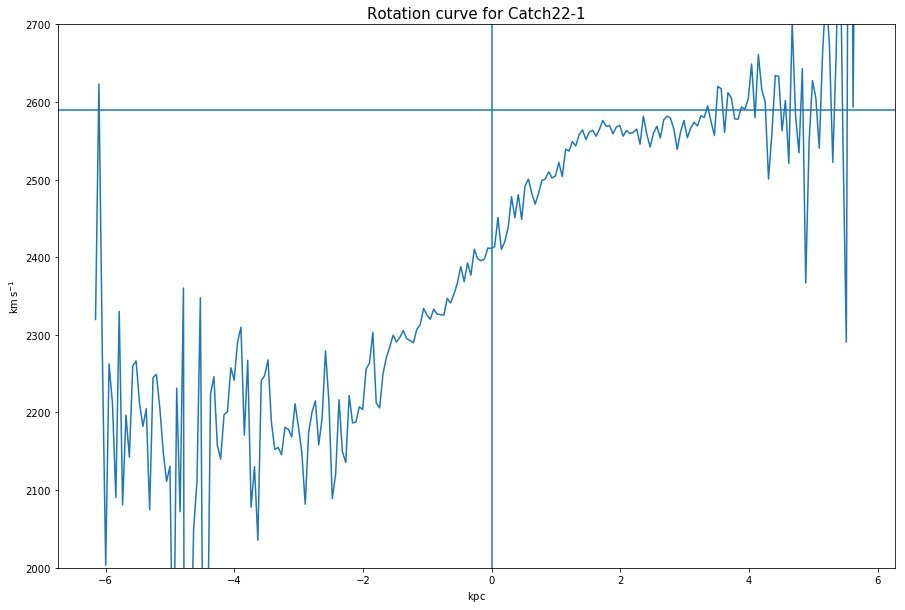

In [57]:
velocity = (checking/(6563*u.angstrom)-1) * c


plt.figure(figsize=(15,10))
plt.plot(u.Quantity(another), u.Quantity(velocity))
plt.title('Rotation curve for Catch22-1',fontsize=15)
plt.axhline(host_z_vel.value)
plt.ylim(2000,2700)
plt.axvline(0)

In [58]:
(checking/(6563*u.angstrom) - 1) *c

<Quantity [ 2319.77305617, 2622.86992875, 2278.46160334, 2003.33590332,
            2262.4238027 , 2211.97768333, 2090.43927682, 2330.17482486,
            2080.89991727, 2196.63799634, 2142.49606287, 2259.85471322,
            2266.35787515, 2211.68071441, 2182.21543701, 2204.78216758,
            2074.93222009, 2245.06362344, 2249.09193218, 2206.32014455,
            2150.09150552, 2111.18433009, 2130.7770508 , 1813.31746981,
            2231.39359771, 2072.214533  , 2360.16205522, -419.49196524,
            1837.98767164, 2049.1466216 , 2111.54124246, 2347.64579654,
            1691.18411268, 1839.30666806, 2223.99560628, 2246.13691563,
            2158.10491372, 2139.95474153, 2197.22993237, 2200.79436466,
            2257.68741401, 2241.55511243, 2290.89071712, 2309.77602528,
            2170.83721671, 2267.33711428, 2078.03859583, 2130.26979765,
            2035.5531357 , 2240.9297564 , 2247.54028829, 2267.57810211,
            2187.47214992, 2152.43644961, 2155.05824381, 2145.62

In [59]:
velocity

<Quantity [ 2319.77305617, 2622.86992875, 2278.46160334, 2003.33590332,
            2262.4238027 , 2211.97768333, 2090.43927682, 2330.17482486,
            2080.89991727, 2196.63799634, 2142.49606287, 2259.85471322,
            2266.35787515, 2211.68071441, 2182.21543701, 2204.78216758,
            2074.93222009, 2245.06362344, 2249.09193218, 2206.32014455,
            2150.09150552, 2111.18433009, 2130.7770508 , 1813.31746981,
            2231.39359771, 2072.214533  , 2360.16205522, -419.49196524,
            1837.98767164, 2049.1466216 , 2111.54124246, 2347.64579654,
            1691.18411268, 1839.30666806, 2223.99560628, 2246.13691563,
            2158.10491372, 2139.95474153, 2197.22993237, 2200.79436466,
            2257.68741401, 2241.55511243, 2290.89071712, 2309.77602528,
            2170.83721671, 2267.33711428, 2078.03859583, 2130.26979765,
            2035.5531357 , 2240.9297564 , 2247.54028829, 2267.57810211,
            2187.47214992, 2152.43644961, 2155.05824381, 2145.62

In [60]:
c

<Quantity 299792.458 km / s>

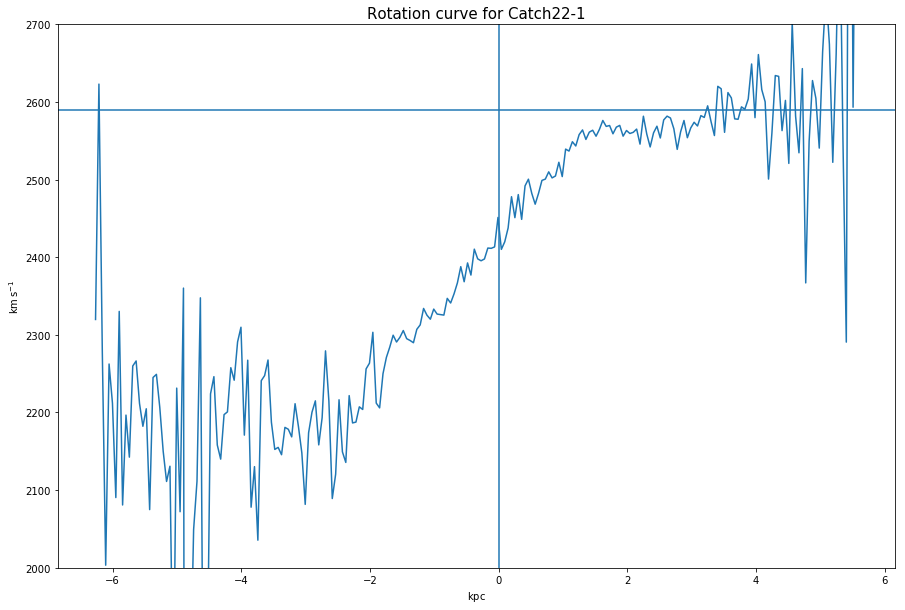

In [61]:
velocity = (checking/(6563*u.angstrom)-1) * c


plt.figure(figsize=(15,10))
plt.plot(u.Quantity(distances_sections), u.Quantity(velocity))
plt.title('Rotation curve for Catch22-1',fontsize=15)
plt.axhline(host_z_vel.value)
plt.ylim(2000,2700)
plt.axvline(0)